### Stock Price Forecasting
- Goal: Predict next-day stock price from past sequence data.
- Dataset: Yahoo Finance (https://pypi.org/project/yfinance/)
- Model: LSTM for regression
- Task Type: Regression
- Extension: Add multi-step forecasting; compare CNN vs. LSTM.

In [1]:
import os
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import yfinance as yf
from LSTM import SimpleLSTM

In [2]:
import yfinance as yf
import pandas as pd
from tabulate import tabulate

symbol = 'GOOGL'
start_date = '2023-11-07'
end_date = '2025-11-06'

stock = yf.Ticker(symbol)
historical_data = stock.history(start=start_date, end=end_date)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print(f"Historical Data for {symbol} from {start_date} to {end_date}")

formatted_data = pd.concat([historical_data.head(), historical_data.tail()])
print(tabulate(formatted_data, headers='keys', tablefmt='psql'))

print("\nShowing only the first and last 5 rows of data:")
print(tabulate(formatted_data, headers='keys', tablefmt='grid'))

Historical Data for GOOGL from 2023-11-07 to 2025-11-06
+---------------------------+---------+---------+---------+---------+-------------+-------------+----------------+
| Date                      |    Open |    High |     Low |   Close |      Volume |   Dividends |   Stock Splits |
|---------------------------+---------+---------+---------+---------+-------------+-------------+----------------|
| 2023-11-07 00:00:00-05:00 | 129.815 | 131.006 | 128.99  | 130.073 | 2.97573e+07 |           0 |              0 |
| 2023-11-08 00:00:00-05:00 | 130.073 | 131.304 | 129.884 | 130.937 | 2.64258e+07 |           0 |              0 |
| 2023-11-09 00:00:00-05:00 | 131.056 | 131.642 | 129.179 | 129.348 | 2.37478e+07 |           0 |              0 |
| 2023-11-10 00:00:00-05:00 | 129.209 | 131.89  | 128.524 | 131.682 | 2.69133e+07 |           0 |              0 |
| 2023-11-13 00:00:00-05:00 | 130.877 | 131.682 | 130.351 | 131.185 | 1.83248e+07 |           0 |              0 |
| 2025-10-30 00:00:00-04

In [3]:
# # Tai toan bo du lieu tu 5 nam tro lai
# dat = yf.download('GOOGL', period='2y')
# # Luu vao file
# dat.to_csv('GOOGL_2y.csv')



In [4]:
# df = pd.read_csv('GOOGL_2y.csv', index_col='Date', parse_dates=True)
# df.head()

# Reproducility & Cấu hình 
Tại sao phải đảm bảo Reproducibility?

Trong mô hình học máy (đặc biệt là LSTM, RNN), có nhiều thứ ngẫu nhiên:

_ Thành phần	Gây biến động kết quả
- Khởi tạo trọng số mô hình | trọng số random → mỗi lần học khác nhau
- Shuffle dữ liệu trong DataLoader | thay đổi cách mô hình học
- Các toán tử trên GPU | một số tính toán không cố định tuyệt đối
- Dropout / data augmentation | tạo random trong quá trình training

➡️ Nếu không cố định seed, bạn chạy hôm nay và chạy lại mai → kết quả khác nhau → không thể tin tưởng hay so sánh.

In [5]:
# Reproducibility: cố định seed để kết quả lặp lại
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

#Cau hinh
CSV_PATH = "GOOGL_2y.csv"
SEQ_LEN = 60 # Window length (60 ngay) dùng 60 ngày trước để dự đoán ngày kế tiếp
BATCH_SIZE = 32
HIDDEN_SIZE = 64
NUM_LAYERS = 2
LR = 0.001
EPOCHS = 200
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ",DEVICE)

Device:  cpu


In [6]:
if not os.path.exists(CSV_PATH):
    print("Không tìm thấy file sạch. Tải dữ liệu GOOGL 2 năm từ yfinance...")
    df_raw = yf.download("GOOGL", period="2y", progress=False)
    # Lưu file gốc tạm
    df_raw.to_csv("GOOGL_2y_raw.csv")
    # Chuẩn hóa tên cột: đảm bảo có Open, High, Low, Close, Volume
    df = df_raw.copy()
    df.to_csv(CSV_PATH)
    print("Đã tải và lưu:", CSV_PATH)
else:
    df = pd.read_csv(CSV_PATH, index_col="Date", parse_dates=True)
    print("Đã đọc file:", CSV_PATH)

print("Dữ liệu tổng:", df.shape)
print(df.head())

Đã đọc file: GOOGL_2y.csv
Dữ liệu tổng: (502, 5)
                 Close        High         Low        Open    Volume
Date                                                                
2023-11-13  131.185211  131.681786  130.350969  130.877337  18324800
2023-11-14  132.704727  134.770481  132.406794  133.270830  32395200
2023-11-15  133.697876  134.105071  132.655080  133.946164  23861500
2023-11-16  135.992050  136.280072  133.399943  134.263979  28013200
2023-11-17  134.383133  135.127995  132.734500  135.068409  37240600


# Chuan hoa & tao sequence

In [7]:
# Lấy cột Close, fit scaler CHỈ trên train (sẽ xác định cutoff sau)
close = df[['Close']].copy()

# Cutoff index theo ti le 70/15/15 tren time series
n_total = len(close)
#Tao sequences, tong samples = n_total - SEQ_LEN
n_samples = n_total - SEQ_LEN
train_samples = int(n_samples*0.70)
val_samples = int(n_samples * 0.15)
test_samples = n_samples - train_samples - val_samples

print(f"Total days: {n_total}, sequence samples: {n_samples}")
print(f"Train samples: {train_samples}, Val samples: {val_samples}, Test samples: {test_samples}")

# --- Fit scaler CHỈ trên phần train (tránh data leakage) ---
# Tuy nhiên scaler cần dữ liệu dạng time-index trước khi tạo sequences.
# Ta fit scaler trên phần 'raw' Close tương ứng với vùng train:
# Range of raw rows included in train portion = train_samples + SEQ_LEN (vì first sample uses first SEQ_LEN days)
train_raw_end = SEQ_LEN + train_samples #exclusive index for raw array slicing
print("train_raw end index (exclusive): ", train_raw_end)      \

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(close.values[:train_raw_end]) # fit only on train portion of raw close values
scaled_all = scaler.transform(close.values) # transform whole series

# tao sequences (sliding window)
X_list, y_list = [], []
for i in range(SEQ_LEN, len(scaled_all)):
    X_list.append(scaled_all[i-SEQ_LEN:i, 0]) # window of length SEQ_LEN
    y_list.append(scaled_all[i, 0]) # next-day target

X = np.array(X_list)
y = np.array(y_list)

#reshape X -> (n_samples, seq_len, n_features)
X = X.reshape(X.shape[0], X.shape[1],1)

print("X shape:", X.shape, "y shape:", y.shape)

# fit scaler = học các thông số để scale dữ liệu từ dataset train, để dữ liệu đưa vào mô hình có cùng thang đo, giúp mô hình học ổn định và tránh rò rỉ thông tin.

Total days: 502, sequence samples: 442
Train samples: 309, Val samples: 66, Test samples: 67
train_raw end index (exclusive):  369
X shape: (442, 60, 1) y shape: (442,)


sử dụng dữ liệu giá đóng cửa với cửa sổ thời gian 60 ngày để dự đoán giá ngày tiếp theo, thu được tổng cộng 441 mẫu. Dữ liệu được chia theo phân vùng thời gian thành 308 mẫu huấn luyện, 66 mẫu dùng để đánh giá trong quá trình huấn luyện và 67 mẫu kiểm tra cuối cùng để đảm bảo mô hình được đánh giá trên dữ liệu chưa từng thấy.

### Chia train/val/test
- Chia theo thứ tự thời gian (không shuffle) để giữ tính chuỗi.

In [8]:
sample_cut_train = train_samples
sample_cut_val = train_samples + val_samples

X_train = X[:sample_cut_train]
y_train =y[:sample_cut_train]

X_val = X[sample_cut_train:sample_cut_val]
y_val = y[sample_cut_train:sample_cut_val]

X_test = X[sample_cut_val:]
y_test = y[sample_cut_val:]

print("Final splits:")
print("  X_train:", X_train.shape, "y_train:", y_train.shape)
print("  X_val:  ", X_val.shape, "y_val:", y_val.shape)
print("  X_test: ", X_test.shape, "y_test:", y_test.shape)

Final splits:
  X_train: (309, 60, 1) y_train: (309,)
  X_val:   (66, 60, 1) y_val: (66,)
  X_test:  (67, 60, 1) y_test: (67,)


# Tao Dataloader
#### Chúng ta sẽ train bằng mini-batches; mỗi batch khởi tạo hidden mới.
Trong quá trình huấn luyện, mỗi khi xử lý 1 batch mới → ta khởi tạo lại hidden state của LSTM về 0.
LSTM ghi nhớ thông tin qua hidden state

Hidden state = bộ nhớ tạm của LSTM trong quá trình xử lý chuỗi.

Nếu bạn không reset hidden state, thì:

- Thông tin từ batch trước len lỏi sang batch sau

- Dữ liệu bị lẫn lộn, vì batch sau không liên quan batch trước
→ mô hình học sai quan hệ thời gian, dẫn đến overfitting và nhiễu.


In [9]:
# Chuyển sang tensor và tạo DataLoader

X_train_t = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
y_train_t = torch.tensor(y_train, dtype=torch.float32).to(DEVICE)
X_val_t = torch.tensor(X_val, dtype=torch.float32).to(DEVICE)
y_val_t = torch.tensor(y_val, dtype=torch.float32).to(DEVICE)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)
y_test_t = torch.tensor(y_test, dtype=torch.float32).to(DEVICE)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds = TensorDataset(X_val_t, y_val_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

print("DataLoaders created. Batch size:", BATCH_SIZE)

DataLoaders created. Batch size: 32


# LSTM
Goi model LSTM da define tu truoc o LSTM.py

In [10]:
from LSTM import SimpleLSTM

model = SimpleLSTM(input_size=1, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, output_size=1).to(DEVICE)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
Giải thích:

- Mỗi epoch lặp qua batches, khởi tạo hidden mới cho mỗi batch.

- Lưu model có val loss nhỏ nhất.

- Dùng gradient clipping để ổn định.

In [11]:
train_losses = []
val_losses = []
best_val_loss = float("inf")
best_epoch = -1

for epoch in range(1, EPOCHS + 1):
    # Training
    model.train()
    running_train_loss = 0.0
    for Xb, yb in train_loader:
        batch_size = Xb.size(0)
        hidden = model.init_hidden(batch_size, DEVICE)

        optimizer.zero_grad()
        preds, _ = model(Xb, hidden)  # preds shape (batch, 1)
        preds = preds.squeeze(1)      # shape (batch,)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0) # prevent exploding grad
        optimizer.step()

        running_train_loss += loss.item() * batch_size
    
    avg_train_loss = running_train_loss / len(train_ds)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for Xb, yb in val_loader:
            batch_size = Xb.size(0)
            hidden = model.init_hidden(batch_size, DEVICE)
            preds, _ = model(Xb, hidden)
            preds = preds.squeeze(1)
            loss = criterion(preds, yb)
            running_val_loss += loss.item() * batch_size
    avg_val_loss = running_val_loss / len(val_ds)
    val_losses.append(avg_val_loss)

    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), "best_simplelstm_goog.pth")

    print(f"Epoch {epoch}/{EPOCHS} — Train MSE: {avg_train_loss:.6f} | Val MSE: {avg_val_loss:.6f}")

print("Training finished. Best val loss:", best_val_loss, "at epoch", best_epoch)

Epoch 1/200 — Train MSE: 0.273975 | Val MSE: 0.155963
Epoch 2/200 — Train MSE: 0.066099 | Val MSE: 0.019970
Epoch 3/200 — Train MSE: 0.039439 | Val MSE: 0.056792
Epoch 4/200 — Train MSE: 0.034214 | Val MSE: 0.019580
Epoch 5/200 — Train MSE: 0.029368 | Val MSE: 0.022706
Epoch 6/200 — Train MSE: 0.023168 | Val MSE: 0.016699
Epoch 7/200 — Train MSE: 0.015741 | Val MSE: 0.009867
Epoch 8/200 — Train MSE: 0.011060 | Val MSE: 0.016560
Epoch 9/200 — Train MSE: 0.008970 | Val MSE: 0.006030
Epoch 10/200 — Train MSE: 0.008204 | Val MSE: 0.004532
Epoch 11/200 — Train MSE: 0.008265 | Val MSE: 0.005107
Epoch 12/200 — Train MSE: 0.007552 | Val MSE: 0.008478
Epoch 13/200 — Train MSE: 0.006308 | Val MSE: 0.010222
Epoch 14/200 — Train MSE: 0.006360 | Val MSE: 0.004548
Epoch 15/200 — Train MSE: 0.005792 | Val MSE: 0.004878
Epoch 16/200 — Train MSE: 0.005298 | Val MSE: 0.004401
Epoch 17/200 — Train MSE: 0.004996 | Val MSE: 0.004087
Epoch 18/200 — Train MSE: 0.004621 | Val MSE: 0.006652
Epoch 19/200 — Trai

# Visualize
Giải thích:

- Quan sát xem có overfitting (train giảm, val tăng) hay underfitting (cả hai cao).

- Dùng kết quả để điều chỉnh epochs, hidden_size, SEQ_LEN, hoặc thêm regularization.

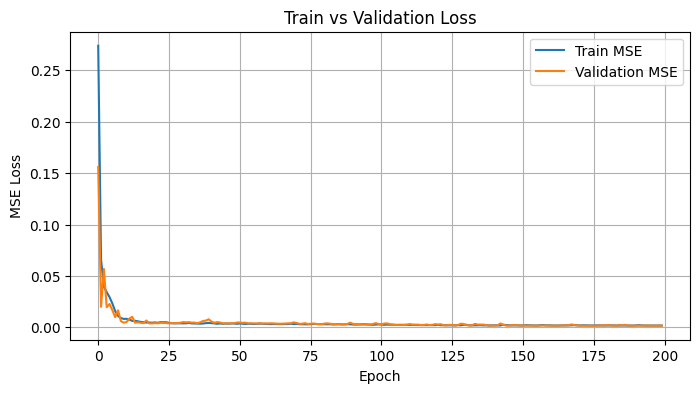

In [12]:
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses, label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


Đồ thị loss cho thấy cả Train Loss và Validation Loss đều giảm ổn định theo thời gian và tiến tới giá trị rất nhỏ (≈ 0.001 → 0.0002). Hai đường loss gần như song song và không tách rời nhau, cho thấy mô hình không gặp hiện tượng overfitting. Điều này chứng tỏ LSTM đã học được xu hướng biến động của giá cổ phiếu và có khả năng khái quát tốt trên dữ liệu chưa từng thấy.

# Đánh giá trên test set

In [13]:
# Cell 9 - Load best model và đánh giá trên tập test -> compute MAE & RMSE
model.load_state_dict(torch.load("best_simplelstm_goog.pth"))
model.eval()

preds_all = []
trues_all = []

with torch.no_grad():
    for Xb, yb in test_loader:
        batch_size = Xb.size(0)
        hidden = model.init_hidden(batch_size, DEVICE)
        preds, _ = model(Xb, hidden)
        preds_all.append(preds.squeeze(1).cpu().numpy())
        trues_all.append(yb.cpu().numpy())

preds_all = np.concatenate(preds_all, axis=0).reshape(-1, 1)  # scaled
trues_all = np.concatenate(trues_all, axis=0).reshape(-1, 1)  # scaled

# Inverse transform to price scale
preds_price = scaler.inverse_transform(preds_all)
trues_price = scaler.inverse_transform(trues_all)

mae = mean_absolute_error(trues_price, preds_price) # Mức chênh lệch trung bình giữa dự đoán và giá thật
mse = mean_squared_error(trues_price, preds_price)  # Phạt sai số lớn mạnh hơn, đo độ ổn định của mô hình
rmse = np.sqrt(mse) # RMSE = √MSE → nên ta tự lấy căn.
r2 = r2_score(trues_price, preds_price)

print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MSE: {mse:.4f}")
print(f"Test R2 score: {r2:.4f}")

Test MAE: 9.3839
Test RMSE: 11.5754
Test MSE: 133.9909
Test R2 score: 0.7998


# Vẽ Predicted vs Actual 
Giải thích:

- Do test samples vẫn theo thứ tự thời gian, trục x chính là thời thứ tự của test samples (không phải dates). Nếu muốn thấy theo ngày thực, ta có index mapping — mình có thể thêm.

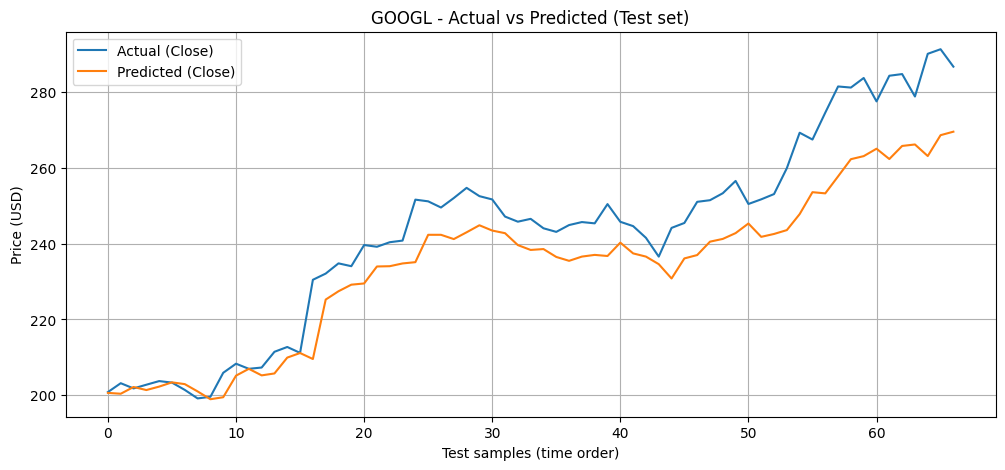

In [14]:
# Plot predictions vs actual (test set)
plt.figure(figsize=(12,5))
plt.plot(trues_price, label="Actual (Close)")
plt.plot(preds_price, label="Predicted (Close)")
plt.xlabel("Test samples (time order)")
plt.ylabel("Price (USD)")
plt.title("GOOGL - Actual vs Predicted (Test set)")
plt.legend()
plt.grid(True)
plt.show()


Hiển thị kết quả với ngày thực để tiện đưa vào báo cáo

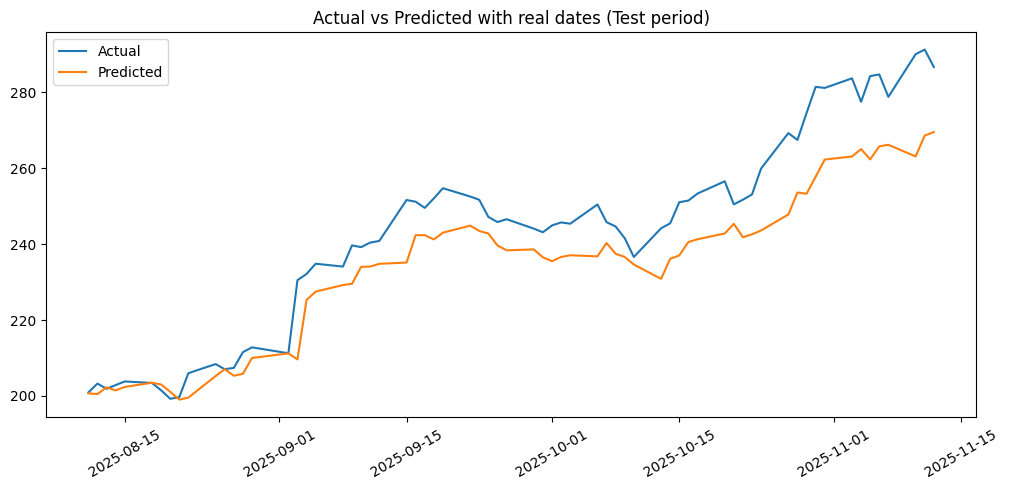

In [16]:
# Optional: map test samples back to original dates for clearer plot
# Khi tạo sequences, sample i corresponds to raw day index i+SEQ_LEN
dates = close.index[SEQ_LEN:]  # dates aligned with X/y samples
test_dates = dates[sample_cut_train + val_samples : sample_cut_train + val_samples + len(trues_price)]
# Nếu lengths khớp, ta có thể dùng test_dates as x-axis
plt.figure(figsize=(12,5))
plt.plot(test_dates, trues_price.flatten(), label="Actual")
plt.plot(test_dates, preds_price.flatten(), label="Predicted")
plt.xticks(rotation=30)
plt.legend()
plt.title("Actual vs Predicted with real dates (Test period)")
plt.show()


# Extension
CNN model

In [17]:
# Cnn model
from CNN import SimpleCNN

cnn_model = SimpleCNN(output_size=1).to(DEVICE)

cnn_loss = torch.nn.MSELoss()
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=LR)


In [18]:
# ----- Training -----
cnn_train_losses = []
cnn_val_losses = []
best_val_loss = float("inf")
best_epoch = -1

for epoch in range(1, EPOCHS + 1):

    # ========== TRAIN ==========
    cnn_model.train()
    running_train_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
        batch_size = Xb.size(0)

        cnn_optimizer.zero_grad()

        preds = cnn_model(Xb).squeeze(1)
        loss = cnn_loss(preds, yb)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(cnn_model.parameters(), 5.0)
        cnn_optimizer.step()

        running_train_loss += loss.item() * batch_size

    avg_train_loss = running_train_loss / len(train_ds)
    cnn_train_losses.append(avg_train_loss)

    # ========== VALIDATION ==========
    cnn_model.eval()
    running_val_loss = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
            batch_size = Xb.size(0)

            preds = cnn_model(Xb).squeeze(1)
            loss = cnn_loss(preds, yb)
            running_val_loss += loss.item() * batch_size

    avg_val_loss = running_val_loss / len(val_ds)
    cnn_val_losses.append(avg_val_loss)

    # Save best
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch
        torch.save(cnn_model.state_dict(), "best_cnn.pth")

    print(f"[CNN] Epoch {epoch}/{EPOCHS} | Train: {avg_train_loss:.6f} | Val: {avg_val_loss:.6f}")

print(f"\nCNN training finished. Best val loss = {best_val_loss:.6f} at epoch {best_epoch}")

[CNN] Epoch 1/200 | Train: 0.209255 | Val: 0.082771
[CNN] Epoch 2/200 | Train: 0.032480 | Val: 0.014206
[CNN] Epoch 3/200 | Train: 0.038459 | Val: 0.018552
[CNN] Epoch 4/200 | Train: 0.028975 | Val: 0.035848
[CNN] Epoch 5/200 | Train: 0.028926 | Val: 0.035678
[CNN] Epoch 6/200 | Train: 0.028409 | Val: 0.025734
[CNN] Epoch 7/200 | Train: 0.027682 | Val: 0.027277
[CNN] Epoch 8/200 | Train: 0.027433 | Val: 0.028293
[CNN] Epoch 9/200 | Train: 0.027520 | Val: 0.030122
[CNN] Epoch 10/200 | Train: 0.027036 | Val: 0.026537
[CNN] Epoch 11/200 | Train: 0.027015 | Val: 0.026169
[CNN] Epoch 12/200 | Train: 0.026684 | Val: 0.026219
[CNN] Epoch 13/200 | Train: 0.026249 | Val: 0.026389
[CNN] Epoch 14/200 | Train: 0.026216 | Val: 0.026346
[CNN] Epoch 15/200 | Train: 0.025320 | Val: 0.022880
[CNN] Epoch 16/200 | Train: 0.024855 | Val: 0.024075
[CNN] Epoch 17/200 | Train: 0.024699 | Val: 0.022768
[CNN] Epoch 18/200 | Train: 0.024470 | Val: 0.024582
[CNN] Epoch 19/200 | Train: 0.023876 | Val: 0.021468
[C

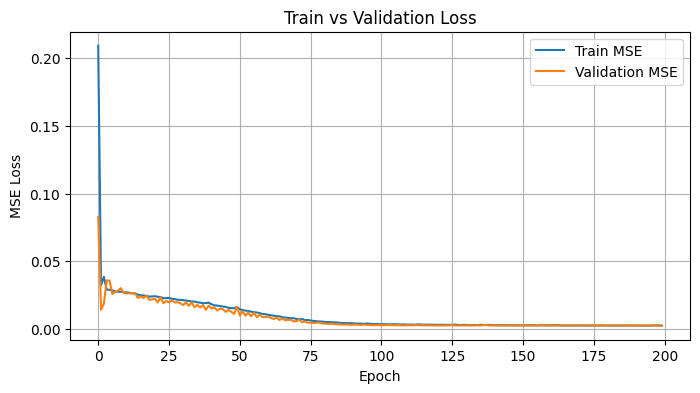

In [19]:
plt.figure(figsize=(8,4))
plt.plot(cnn_train_losses, label="Train MSE")
plt.plot(cnn_val_losses, label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Load best model
cnn_model.load_state_dict(torch.load("best_cnn.pth"))
cnn_model.eval()

cnn_preds_all = []
cnn_trues_all = []

with torch.no_grad():
    for Xb, yb in test_loader:
        Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
        preds = cnn_model(Xb).squeeze(1)  # <-- đây là dòng bạn thiếu
        cnn_preds_all.append(preds.cpu().numpy())
        cnn_trues_all.append(yb.cpu().numpy())

cnn_preds_all = np.concatenate(cnn_preds_all, axis=0).reshape(-1, 1)
cnn_trues_all = np.concatenate(cnn_trues_all, axis=0).reshape(-1, 1)

# Inverse scale
cnn_preds_price = scaler.inverse_transform(cnn_preds_all)
cnn_trues_price = scaler.inverse_transform(cnn_trues_all)

cnn_mae = mean_absolute_error(cnn_trues_price, cnn_preds_price)
cnn_mse = mean_squared_error(cnn_trues_price, cnn_preds_price)
cnn_rmse = np.sqrt(cnn_mse)
cnn_r2 = r2_score(cnn_trues_price, cnn_preds_price)

print(f"Test MAE: {cnn_mae:.4f}")
print(f"Test RMSE: {cnn_rmse:.4f}")
print(f"Test MSE: {cnn_mse:.4f}")
print(f"Test R2 score: {cnn_r2:.4f}")


Test MAE: 18.8454
Test RMSE: 21.5388
Test MSE: 463.9219
Test R2 score: 0.3068


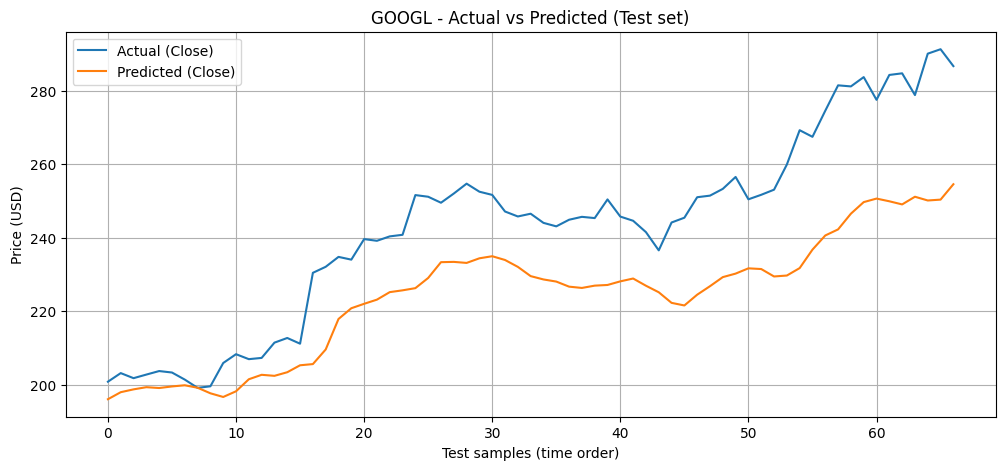

In [21]:
# Plot predictions vs actual (test set)
plt.figure(figsize=(12,5))
plt.plot(cnn_trues_price, label="Actual (Close)")
plt.plot(cnn_preds_price, label="Predicted (Close)")
plt.xlabel("Test samples (time order)")
plt.ylabel("Price (USD)")
plt.title("GOOGL - Actual vs Predicted (Test set)")
plt.legend()
plt.grid(True)
plt.show()

# CNN vs LSTM

In [22]:
#Hàm tính toán chung cho mae rmse r2 
def evaluate_model(model, test_loader, scaler, device, model_type="cnn"):
    model.eval()
    preds_all, trues_all = [], []

    with torch.no_grad():
        for Xb, yb in test_loader:
            Xb, yb = Xb.to(device), yb.to(device)

            if model_type == "lstm":
                batch_size = Xb.size(0)
                hidden = model.init_hidden(batch_size, device)
                preds, _ = model(Xb, hidden)
            else:  # cnn
                preds = model(Xb)

            preds_all.append(preds.squeeze(1).cpu().numpy())
            trues_all.append(yb.cpu().numpy())

    preds_all = np.concatenate(preds_all, axis=0).reshape(-1,1)
    trues_all = np.concatenate(trues_all, axis=0).reshape(-1,1)

    preds_price = scaler.inverse_transform(preds_all)
    trues_price = scaler.inverse_transform(trues_all)

    mae = mean_absolute_error(trues_price, preds_price)
    mse = mean_squared_error(trues_price, preds_price)
    rmse = np.sqrt(mse)
    r2 = r2_score(trues_price, preds_price)

    return mae, mse, rmse, r2


In [23]:
cnn_model.load_state_dict(torch.load("best_cnn.pth"))
model.load_state_dict(torch.load("best_simplelstm_goog.pth"))

cnn_metrics = evaluate_model(cnn_model, test_loader, scaler, DEVICE, model_type="cnn")
lstm_metrics = evaluate_model(model, test_loader, scaler, DEVICE, model_type="lstm")

print(f"CNN - MAE: {cnn_metrics[0]:.4f}, RMSE: {cnn_metrics[2]:.4f}, R2: {cnn_metrics[3]:.4f}")
print(f"LSTM - MAE: {lstm_metrics[0]:.4f}, RMSE: {lstm_metrics[2]:.4f}, R2: {lstm_metrics[3]:.4f}")


CNN - MAE: 18.8454, RMSE: 21.5388, R2: 0.3068
LSTM - MAE: 9.3839, RMSE: 11.5754, R2: 0.7998
